# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
weights = {'^GSPC': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}
symbols = list(weights.keys())
directions = {'^GSPC': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,^GSPC_high,^GSPC_low,^GSPC_close,TLT_high,TLT_low,TLT_close,GLD_high,GLD_low,GLD_close,TLT_SHRT_high,TLT_SHRT_low,TLT_SHRT_close
date,,,,,,,,,,,,
1927-12-30,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-03,17.76,17.76,17.76,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-04,17.72,17.72,17.72,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-05,17.55,17.55,17.55,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-06,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,3387.59,3379.22,3381.99,164.46,163.43,163.59,187.01,184.66,186.50,164.46,163.43,163.59
2020-08-18,3395.06,3370.15,3389.78,164.87,164.09,164.76,189.40,185.63,188.18,164.87,164.09,164.76
2020-08-19,3399.54,3369.66,3374.85,165.61,163.30,163.73,187.46,181.71,182.24,165.61,163.30,163.73


In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital, margin=2)
pf.TradeLog.instance

{'^GSPC': <pinkfish.trade.TradeLog at 0x7f71b0c1e6a0>,
 'TLT': <pinkfish.trade.TradeLog at 0x7f71b0c1e850>,
 'GLD': <pinkfish.trade.TradeLog at 0x7f71b0c1e8b0>,
 'TLT_SHRT': <pinkfish.trade.TradeLog at 0x7f71b0c1ed00>}

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = portfolio.get_row_column_value(row, symbol)
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,1191.37,8,entry,LONG,^GSPC
1,2004-12-01,1,51.41,116,entry,LONG,TLT
2,2004-12-01,2,45.38,44,entry,LONG,GLD
3,2004-12-01,3,51.41,38,entry,SHRT,TLT_SHRT
4,2005-01-03,4,52.97,2,exit,LONG,TLT
5,2005-01-03,5,43.02,2,entry,LONG,GLD
6,2005-02-01,6,54.66,4,exit,LONG,TLT
7,2005-02-01,7,42.10,1,entry,LONG,GLD
8,2005-02-01,8,54.66,2,exit,SHRT,TLT_SHRT
9,2005-03-01,9,53.92,4,entry,LONG,TLT


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
355,2016-05-02,2081.43,2020-08-21,3397.16,1315.73,1315.73,1,37848.20,LONG,^GSPC
356,2016-06-01,115.94,2020-04-01,149.45,33.51,100.53,3,37948.73,LONG,GLD
357,2016-06-01,115.94,2020-08-03,185.64,69.70,69.70,1,38018.43,LONG,GLD
358,2016-07-01,2102.95,2020-08-21,3397.16,1294.21,1294.21,1,39312.64,LONG,^GSPC
359,2016-08-01,127.15,2020-04-01,166.23,39.08,195.42,5,39508.06,LONG,TLT
...,...,...,...,...,...,...,...,...,...,...
450,2020-07-01,163.24,2020-08-21,166.20,2.96,8.88,3,53867.29,LONG,TLT
451,2020-07-01,163.24,2020-08-21,166.20,-2.96,-2.96,1,53864.33,SHRT,TLT_SHRT
452,2020-08-03,3294.61,2020-08-21,3397.16,102.55,102.55,1,53966.88,LONG,^GSPC
453,2020-08-03,169.95,2020-08-21,166.20,-3.75,-41.25,11,53925.63,LONG,TLT


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-08-17,63561.86,63561.86,63561.86,380,-55590.13,1.87,-
2020-08-18,63995.59,63995.59,63995.59,380,-55590.13,1.87,-
2020-08-19,63161.50,63161.50,63161.50,380,-55590.13,1.88,-
2020-08-20,63667.50,63667.50,63667.50,380,-55590.13,1.87,-
2020-08-21,63936.88,63936.88,63936.88,0,63936.88,1.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2020-08-21
beginning_balance                                           10000
ending_balance                                           63936.88
total_net_profit                                         53936.88
gross_profit                                             61778.73
gross_loss                                               -7841.85
profit_factor                                                7.88
return_on_initial_capital                                  539.37
annual_return_rate                                          12.50
trading_period                           15 years 9 months 3 days
pct_time_in_market                                          99.80
margin                                                          2
avg_leverage                                                 1.89
max_leverage                                                 2.16
min_levera

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.59
2020-08-21 00:00:00 SELL 115 SPY @ 339.48


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

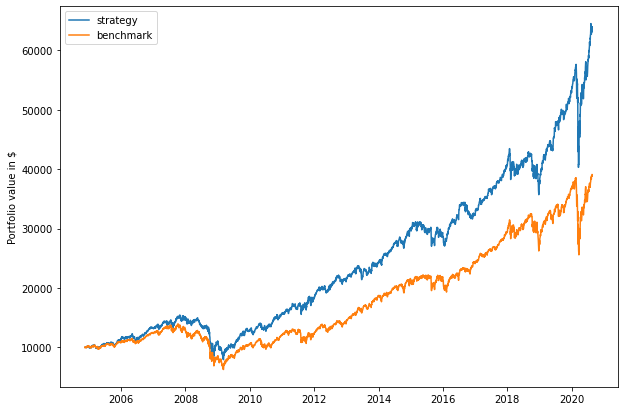

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

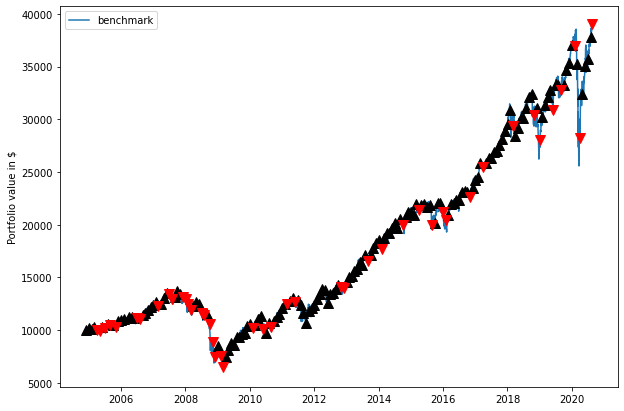

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$63,936.88","$39,081.94"
total_net_profit,"$53,936.88","$29,081.94"
gross_profit,"$61,778.73","$29,081.94"
gross_loss,"-$7,841.85",$0.00


,strategy,benchmark
annual_return_rate,12.50,9.04
max_closed_out_drawdown,-48.65,-55.02
drawdown_annualized_return,-3.89,-6.09
drawdown_recovery,-1.36,-1.42
best_month,29.43,23.46
worst_month,-30.08,-30.95
sharpe_ratio,0.76,0.54
sortino_ratio,0.94,0.64
monthly_std,4.38,4.57
annual_std,14.84,15.50


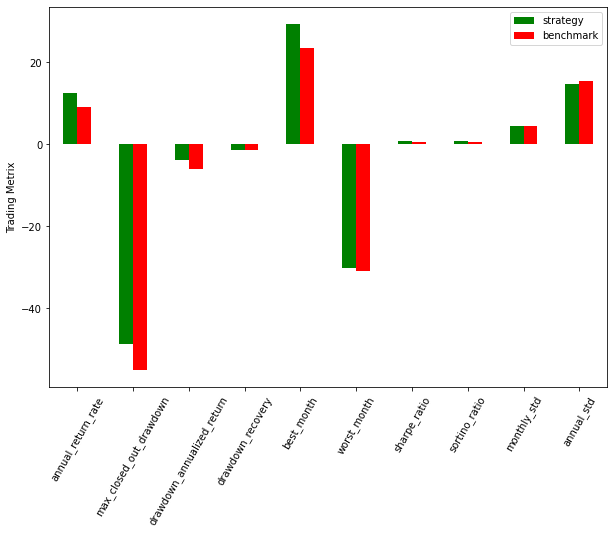

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df